In this example we will see how to plot an hexagonal map that reflects the results of the training process. This example is an extension of BasicUsage.ipynb. Only the plotting section has new code.

In [1]:
from minisom_gpu.som import MiniSom

import pandas as pd
import numpy as np
import torch


import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

device = 'cuda'

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook
output_notebook()

Loading BokehJS ...

## Data Load, Preprocess and Training
We load the seeds dataset, normalise the data along the columns and then train our SOMs. 

> Note, we are training a hexagonal topology because we will be plotting this.

In [2]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                   names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                          'asymmetry_coefficient', 'length_kernel_groove', 'target'], 
                   sep='\t+')
t = data['target'].values
data = data[data.columns[:-1]]

# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = torch.tensor(data.values, dtype=torch.float32, device=device)

# initialization and training of 15x15 SOM
som = MiniSom(15, 15, data.shape[1], sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10, device=device)

som.train(data, 1000, verbose=True)

/tmp/ipykernel_12796/3215761009.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: tensor(0.3179)


***

## Plotting: matplotlib
Below, we are plotting using matplotlib to create a static hexagonal topology.

In [3]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map().numpy()
weights = som.get_weights().numpy()

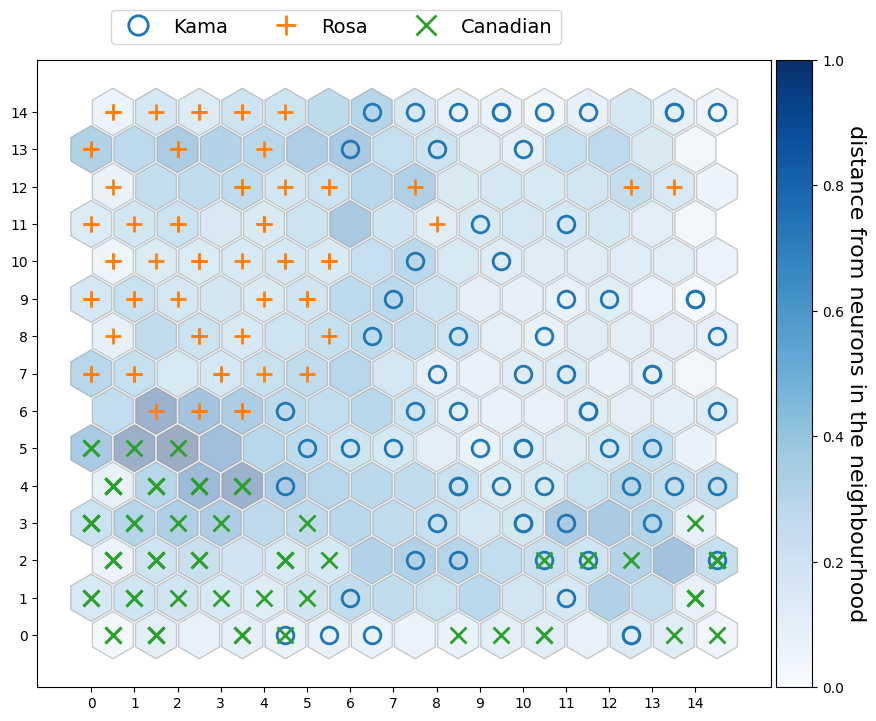

In [4]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', '+', 'x']
colors = ['C0', 'C1', 'C2']
for cnt, x in enumerate(data):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2
    plt.plot(wx, wy, 
             markers[t[cnt]-1], 
             markerfacecolor='None',
             markeredgecolor=colors[t[cnt]-1], 
             markersize=12, 
             markeredgewidth=2)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

legend_elements = [Line2D([0], [0], marker='o', color='C0', label='Kama',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='+', color='C1', label='Rosa',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='x', color='C2', label='Canadian',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
          borderaxespad=0., ncol=3, fontsize=14)

plt.savefig('resulting_images/som_seed_hex.png')
plt.show()

## Plotting: bokeh
Below, we are plotting using bokeh to create an interactive hexagonal topology.

> Note: Compared to matplotlib plot, this is rotated 90 degrees.

In [5]:
hex_centre_col, hex_centre_row = [], []
hex_colour = []
label = []

# define labels
SPECIES = ['Kama', 'Rosa', 'Canadian']

for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex_centre_col.append(xx[(i, j)].item())
        hex_centre_row.append(wy.item())
        hex_colour.append(cm.Blues(umatrix[i, j].item()))

weight_x, weight_y = [], []
for cnt, i in enumerate(data):
    w = som.winner(i)
    wx, wy = som.convert_map_to_euclidean(xy=w)
    wy = wy * np.sqrt(3) / 2
    weight_x.append(wx.item())
    weight_y.append(wy.item())
    label.append(SPECIES[t[cnt]-1])
    
# convert matplotlib colour palette to bokeh colour palette
hex_plt = [(255 * np.array(i)).astype(int) for i in hex_colour]
hex_bokeh = [RGB(*tuple(rgb)).to_hex() for rgb in hex_plt]

In [6]:
output_file("resulting_images/som_seed_hex.html")

# initialise figure/plot
fig = figure(title="SOM: Hexagonal Topology",
             height=800, width=800,
             match_aspect=True,
             tools="wheel_zoom,save,reset")

# create data stream for plotting
source_hex = ColumnDataSource(
    data = dict(
        x=hex_centre_col,
        y=hex_centre_row,
        c=hex_bokeh
    )
)

source_pages = ColumnDataSource(
    data=dict(
        wx=weight_x,
        wy=weight_y,
        species=label
    )
)

# define markers
MARKERS = ['diamond', 'cross', 'x']

# add shapes to plot
fig.hex(x='y', y='x', source=source_hex,
        size=100 * (.95 / np.sqrt(3)),
        alpha=.4,
        line_color='gray',
        fill_color='c')

fig.scatter(x='wy', y='wx', source=source_pages, 
            legend_field='species',
            size=20, 
            marker=factor_mark(field_name='species', markers=MARKERS, factors=SPECIES),
            color=factor_cmap(field_name='species', palette='Category10_3', factors=SPECIES))

# add hover-over tooltip
fig.add_tools(HoverTool(
    tooltips=[
        ("label", '@species'),
        ("(x,y)", '($x, $y)')],
    mode="mouse", 
    point_policy="follow_mouse"
))

show(fig)

![bokeh plot](https://htmlpreview.github.io/?https://github.com/JustGlowing/minisom/blob/master/examples/resulting_images/som_seed_hex.html)